In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

In [3]:
# Load Data
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# Drop unnecessary features
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [6]:
data.columns = ['label', 'sms']

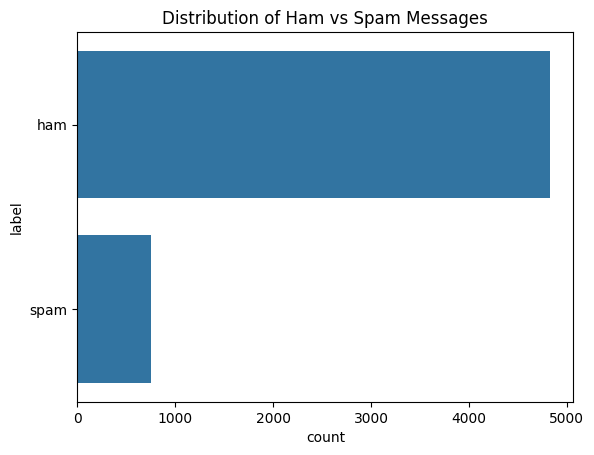

In [7]:
# Label distribution
sns.countplot(data['label'])
plt.title('Distribution of Ham vs Spam Messages')
plt.show()

Data is unbalanced in "Ham"'s favor

## Data Preprocessing

In [8]:
# Convert label to binary (ham -> 0, spam -> 1)
data['label'] = data['label'].map({'spam': 1, 'ham': 0})

In [9]:
import re

# Only convert to lowercase without removing numbers
data['sms_clean'] = data['sms'].str.lower()

# Remove punctuations but keep numbers
data['sms_clean'] = data['sms_clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

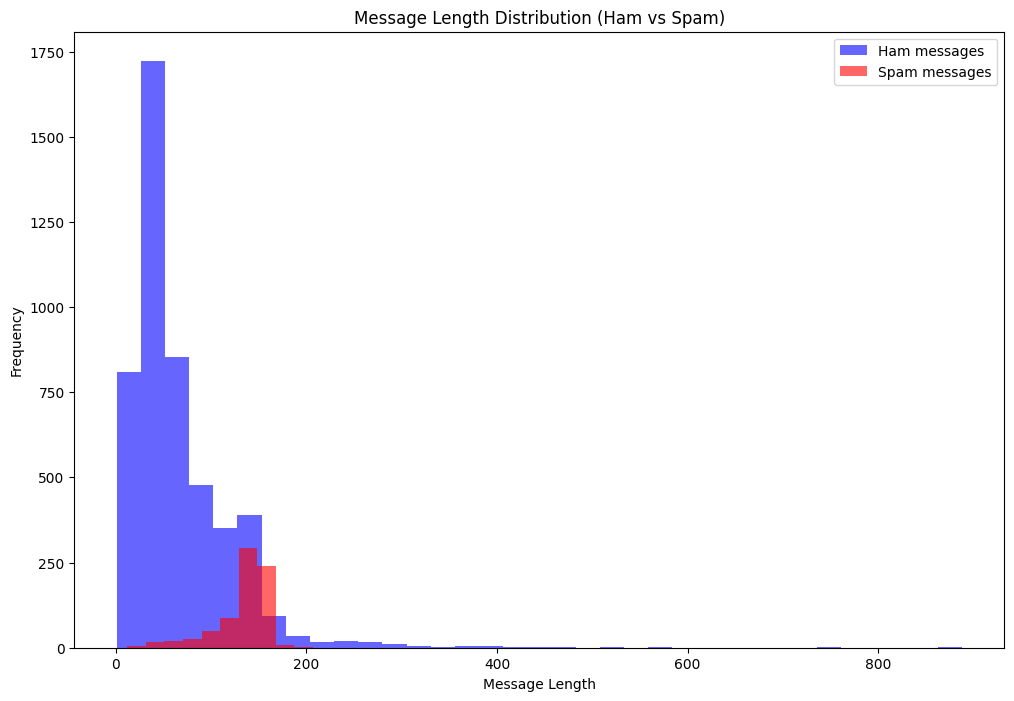

In [10]:
# Visualizing message length distribution for ham vs spam using matplotlib
data['length'] = data['sms_clean'].apply(len)

plt.figure(figsize=(12, 8))

# Plotting histogram for Ham messages
data[data.label == 0].length.plot(bins=35, kind='hist', color='blue',
                                    label='Ham messages', alpha=0.6)

# Plotting histogram for Spam messages
data[data.label == 1].length.plot(kind='hist', color='red',
                                    label='Spam messages', alpha=0.6)

plt.legend()
plt.xlabel("Message Length")
plt.title('Message Length Distribution (Ham vs Spam)')  # Adding title for clarity
plt.ylabel('Frequency')  # Adding ylabel for clarity
plt.show()


In [11]:
#Feature Engineering (TF-IDF)
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X = tfidf.fit_transform(data['sms_clean'])
y = data['label']


In [12]:
# Balance the dataset using RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [13]:
# Visualizing most important words using TF-IDF scores
tfidf_words = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names_out(), columns=["idf_weights"]).sort_values(by='idf_weights')
print(tfidf_words.head(10))

      idf_weights
im       3.578317
just     3.745156
ur       3.898841
ok       4.023570
dont     4.108236
know     4.132627
ill      4.178951
got      4.196343
like     4.200739
free     4.209588


In [14]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building and Training

In [15]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

## Model Evaluation

In [16]:
# Predictions and accuracy
y_pred = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [17]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [18]:
# Classification report
class_report = classification_report(y_test, y_pred)

In [19]:
# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(class_report)

Accuracy: 0.9668
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



## Visualization of Model Performance

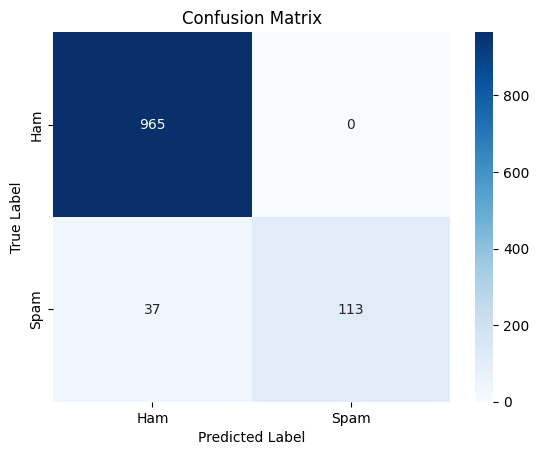

In [20]:
# Confusion matrix visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
# ROC Curve and AUC
y_prob = nb_classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (spam)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

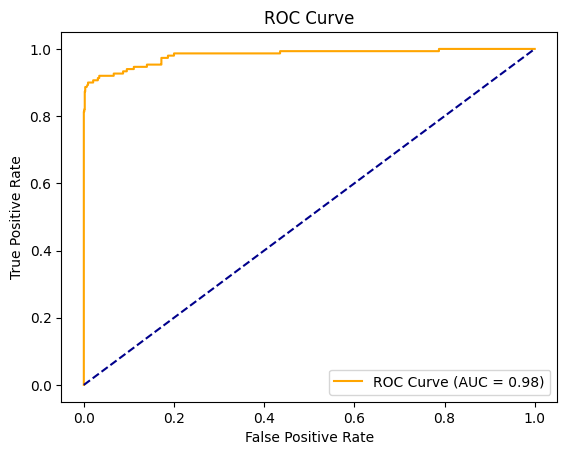

In [22]:
plt.plot(fpr, tpr, color='orange', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()